In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
print('No. of GPU:- ',len(tf.config.list_physical_devices('GPU')))
print('No. of CPU:- ',len(tf.config.list_physical_devices('CPU')))

No. of GPU:-  2
No. of CPU:-  1


In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
os.chdir='/kaggle/input/chest-xray-pneumonia/chest_xray/'

In [5]:
os.getcwd()

'/kaggle/working'

In [6]:
train_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/val'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    zca_whitening=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
)


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1054: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [9]:

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    save_to_dir='/kaggle/working/',    # Save augmented images here
    save_format='jpeg' 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Assuming your test directory has the structure
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [13]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20


2024-10-05 11:21:56.760351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_720/cond/StatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 929ms/step - accuracy: 0.7170 - loss: 0.5946 - val_accuracy: 0.5000 - val_loss: 0.7871
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 646ms/step - accuracy: 0.7439 - loss: 0.5833 - val_accuracy: 0.5000 - val_loss: 0.8376
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 644ms/step - accuracy: 0.7465 - loss: 0.5774 - val_accuracy: 0.6250 - val_loss: 0.7152
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 642ms/step - accuracy: 0.7430 - loss: 0.5780 - val_accuracy: 0.5000 - val_loss: 0.8541
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 674ms/step - accuracy: 0.7307 - loss: 0.5860 - val_accuracy: 0.8750 - val_loss: 0.4245
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 641ms/step - accuracy: 0.7473 - loss: 0.5729 - val_accuracy: 0.2500 - val_loss: 1.0414
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 645ms/step - accuracy: 0.7369 - loss: 0.5786 - val_accuracy: 0.5000 - val_loss: 0.8240
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 645ms/step - accuracy: 0.7432 - loss: 0.57

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,542,251 (17.33 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 328,454 (1.25 MB)

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - accuracy: 0.2977 - loss: 1.0610
Test Loss: 0.7178
Test Accuracy: 60.90%


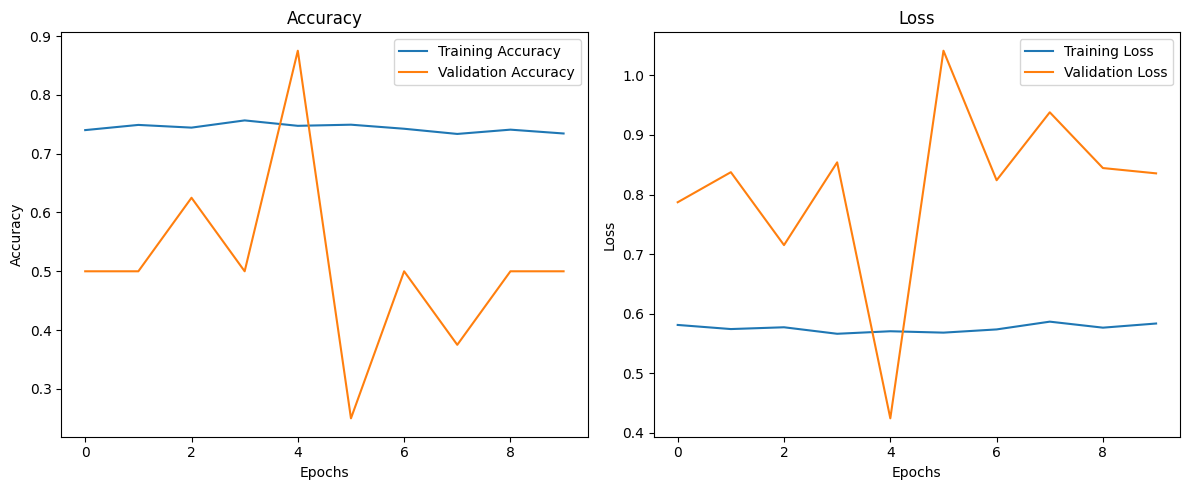

In [16]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


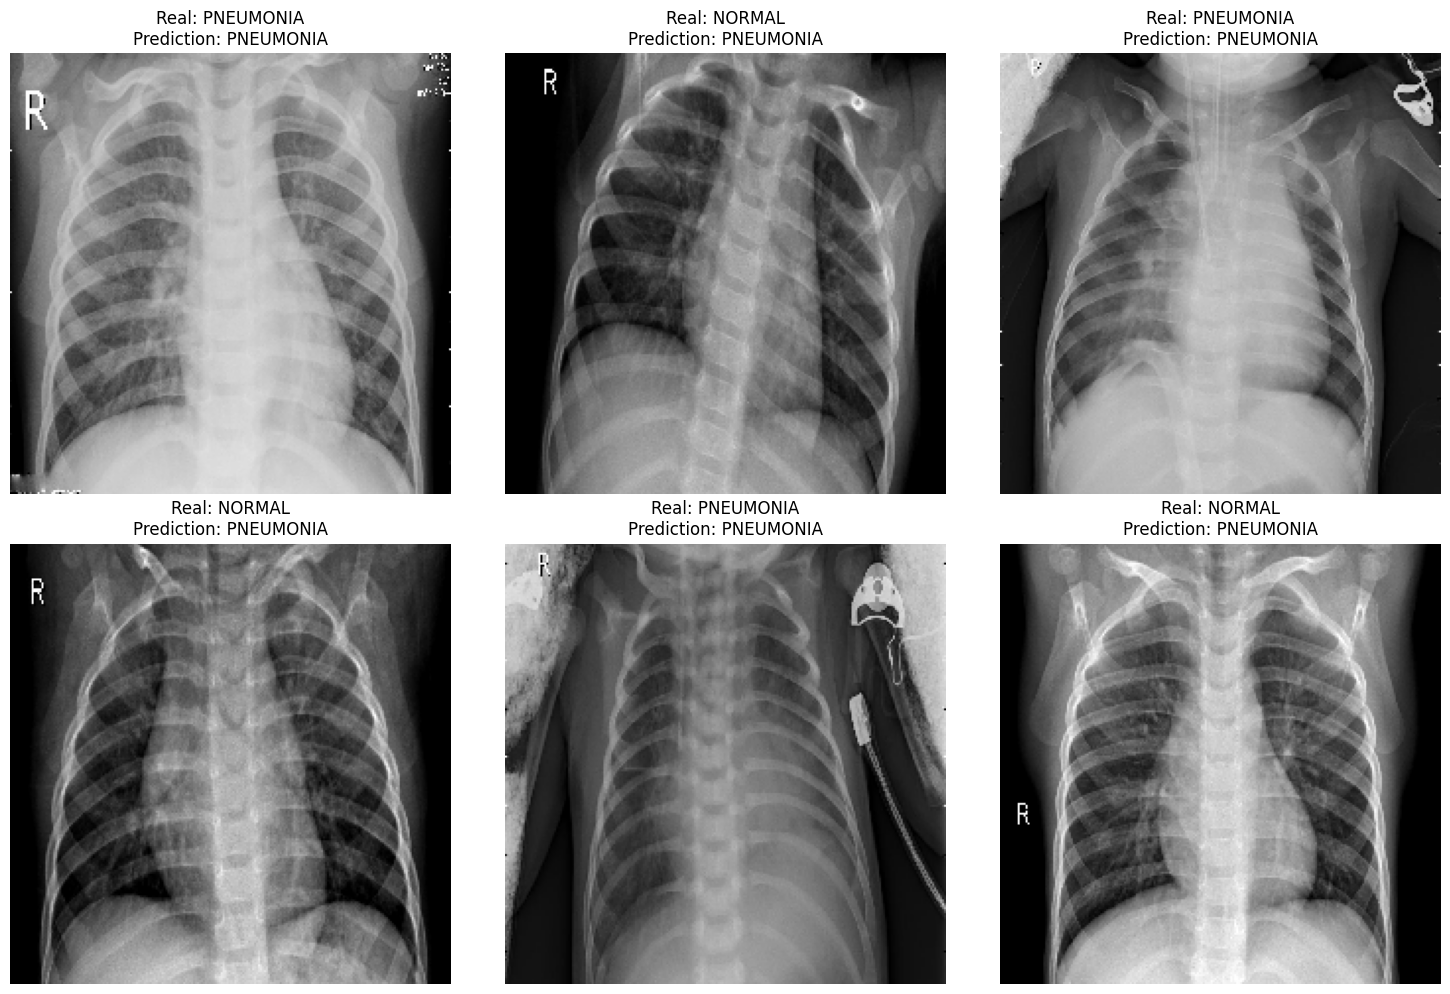

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Set the number of images to display
num_images = 6

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Combined test directory
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Get all images from both NORMAL and PNEUMONIA classes
test_images_normal = os.listdir(os.path.join(test_dir, 'NORMAL'))
test_images_pneumonia = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))

# Create a list of tuples (file path, real label) for each image
test_images = [(os.path.join(test_dir, 'NORMAL', img), 'NORMAL') for img in test_images_normal] + \
              [(os.path.join(test_dir, 'PNEUMONIA', img), 'PNEUMONIA') for img in test_images_pneumonia]

# Randomly select `num_images` images from the combined list using their indices
selected_indices = np.random.choice(len(test_images), num_images, replace=False)
selected_images = [test_images[i] for i in selected_indices]

# Create a figure for displaying the images and their predictions
plt.figure(figsize=(15, 10))

# Predict and display each image
for i, (img_path, real_label) in enumerate(selected_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Corrected target_size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Plot the image with its predicted label and real label
    plt.subplot(2, 3, i + 1)  # Create a subplot grid (2 rows, 3 columns)
    plt.imshow(img)
    plt.title(f'Real: {real_label}\nPrediction: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# Enable logging of device placement
tf.debugging.set_log_device_placement(True)


In [41]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())  # Adding Batch Normalization here
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)


Epoch 1/25


2024-10-05 12:05:17.590272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_1580/cond/StatefulPartitionedCall/replica_1/sequential_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 ━━━━━━━━━━━━━━━━━━━━ 254s 764ms/step - accuracy: 0.7994 - loss: 0.5907 - val_accuracy: 0.3750 - val_loss: 3.1647
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 706ms/step - accuracy: 0.9100 - loss: 0.2489 - val_accuracy: 0.7500 - val_loss: 1.0220
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 709ms/step - accuracy: 0.9250 - loss: 0.2049 - val_accuracy: 0.5000 - val_loss: 5.6700
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 701ms/step - accuracy: 0.9062 - loss: 0.4019 - val_accuracy: 0.7500 - val_loss: 3.5337
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 707ms/step - accuracy: 0.9338 - loss: 0.1832 - val_accuracy: 0.3750 - val_loss: 2.0339
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 701ms/step - accuracy: 0.9082 - loss: 0.3720 - val_accuracy: 0.6250 - val_loss: 0.6170
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 708ms/step - accuracy: 0.8825 - loss: 0.3842 - val_accuracy: 0.6250 - val_loss: 1.7645
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 709ms/step - accuracy: 0.9148 - loss: 0.25

In [44]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,567,587 (47.94 MB)

 Trainable params: 4,174,334 (15.92 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,348,670 (31.85 MB)

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 595ms/step - accuracy: 0.7161 - loss: 1.9329
Test Loss: 0.6078
Test Accuracy: 86.54%


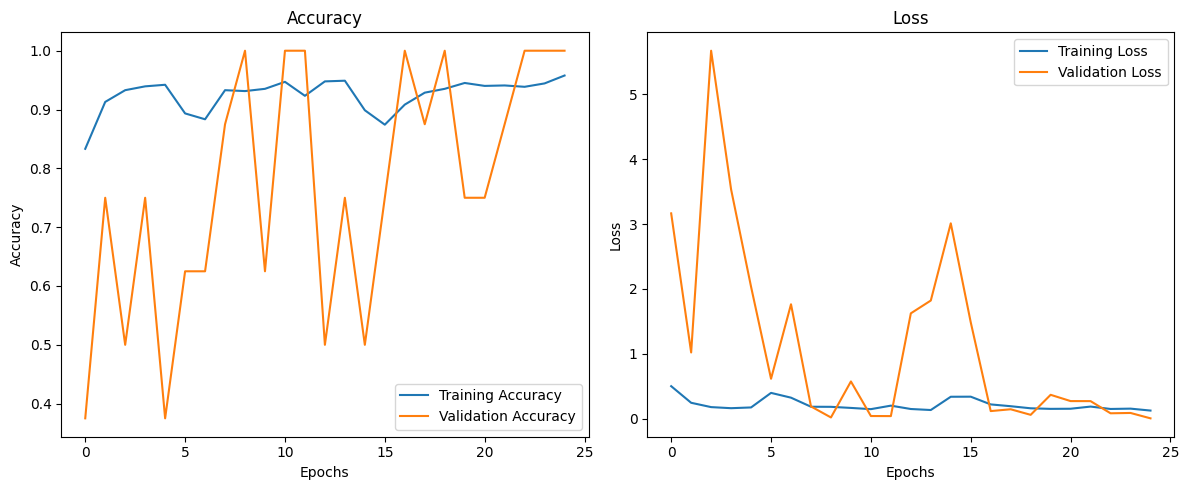

In [46]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


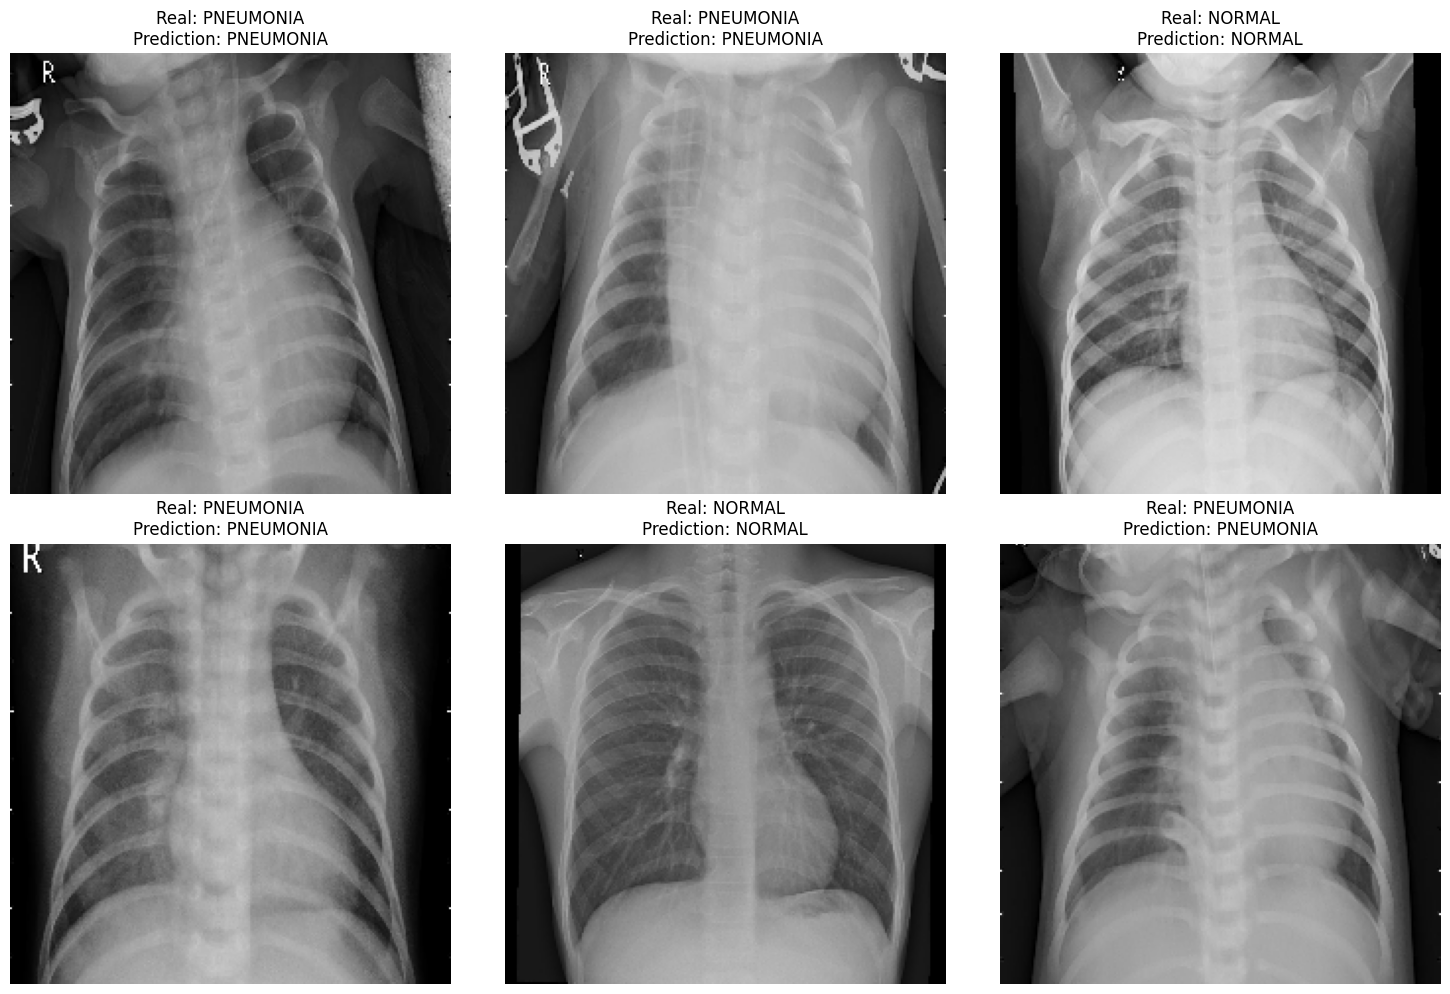

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Combined test directory
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Get all images from both NORMAL and PNEUMONIA classes
test_images_normal = os.listdir(os.path.join(test_dir, 'NORMAL'))
test_images_pneumonia = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))

# Create a list of tuples (file path, real label) for each image
test_images = [(os.path.join(test_dir, 'NORMAL', img), 'NORMAL') for img in test_images_normal] + \
              [(os.path.join(test_dir, 'PNEUMONIA', img), 'PNEUMONIA') for img in test_images_pneumonia]

# Number of images to sample
num_images = 6  # Set this to your desired number

# Randomly select `num_images` images from the combined list using their indices
selected_indices = np.random.choice(len(test_images), num_images, replace=False)
selected_images = [test_images[i] for i in selected_indices]

# Create a figure for displaying the images and their predictions
plt.figure(figsize=(15, 10))

# Predict and display each image
for i, (img_path, real_label) in enumerate(selected_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Change target size to 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Plot the image with its predicted label and real label
    plt.subplot(2, 3, i + 1)  # Create a subplot grid (2 rows, 3 columns)
    plt.imshow(img)
    plt.title(f'Real: {real_label}\nPrediction: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step


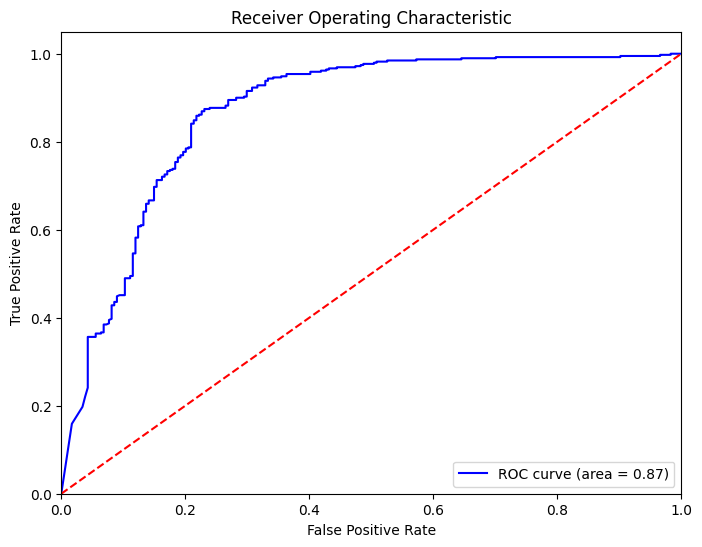

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model  # If you're loading a model, ensure you have this import

# Assuming test_generator is already defined and model is loaded

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)

# True classes
true_classes = test_generator.classes

# Compute ROC curve and ROC area for the positive class (PNEUMONIA)
fpr, tpr, _ = roc_curve(true_classes, predictions[:, 1])  # Positive class (PNEUMONIA)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 788ms/step


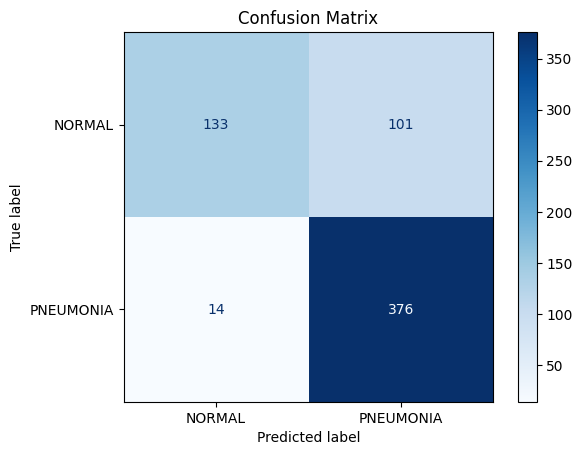

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
